# Exploring the UTx000 Extension Beiwe Data
(Known as BPEACE2 in the [GH repo](https://github.com/intelligent-environments-lab/utx000))

# GPS Inspection
The GPS data are a little wonky, so I want to take a closer look.

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Package Import

In [2]:
import sys
sys.path.append('../')

from src.features import build_features
from src.visualization import visualize
from src.reports import make_report

import pandas as pd
import numpy as np

from datetime import datetime, timedelta
import math

import matplotlib.pyplot as plt

# Data Import

## GPS Data
The GPS data are available in the ```processed``` directory

In [3]:
gps = pd.read_csv('../data/processed/bpeace2-gps-original.csv', index_col=0, parse_dates=True, infer_datetime_format=True)
gps.tail()

,UTC Time,Lat,Long,Alt,Accuracy,Beiwe
Time,,,,,,
2020-09-02 04:27:15.999,2020-09-02T09:27:15.999,30.36728,-97.79331,248.80050,5.12092,zdpffrox
2020-09-02 04:27:16.999,2020-09-02T09:27:16.999,30.36728,-97.79331,248.80050,5.11290,zdpffrox
2020-09-02 04:27:17.999,2020-09-02T09:27:17.999,30.36728,-97.79331,248.80050,5.10805,zdpffrox
2020-09-02 04:29:11.145,2020-09-02T09:29:11.145,30.36718,-97.79324,245.49971,65.00000,zdpffrox
2020-09-02 04:37:18.698,2020-09-02T09:37:18.698,30.36718,-97.79324,245.49971,112.29229,zdpffrox


In [4]:
n = len(gps['Beiwe'].unique())
print(f'Number of Beiwe participants: {n}')

Number of Beiwe participants: 52


## Address Information
We can also take a look at how well the GPS coordinates tend to match up with addresses

In [5]:
info = pd.read_excel('../data/raw/bpeace2/admin/id_crossover.xlsx',sheet_name='beacon')
info.head()

,REDCap,Beiwe,Beacon,start_date,end_date,move_date,return_date,Lat,Long,Original Address,Volume,Housemates,Roommates,Number of Rooms,NO2,original_start,original_end,original_move
0,10,kyj367pi,1,2020-06-08 13:00:00,2020-09-03,2020-07-31,2020-09-02,30.312614,-97.732338,"2822 Rio Grande St. Apt 202 Austin, TX, 78705",1080,0,0,1.0,Yes,2020-06-15,NaT,2020-09-14
1,55,745vq78e,5,2020-06-09 10:21:00,2020-08-23,NaT,2020-09-08,30.288012,-97.751201,"18207 Branson Falls San Antonio, TX 78255",1188,0,0,5.0,Yes,2020-06-15,NaT,2020-08-17
2,61,itmylz3g,6,2020-06-17 14:08:00,2020-09-01,NaT,2020-09-01,29.855371,-95.741200,"5403 Dunsmore Harbor Ln, Katy, TX 77449",1188,0,0,5.0,Yes,2020-06-15,2020-09-11,2020-07-03
3,0,zdpffrox,7,2020-06-01 00:00:00,2020-09-01,NaT,2020-09-01,30.326815,-97.744665,"2211 Lawnmont Avenue apt 314 Austin, TX 78756",1365,1,1,NaN,Yes,2020-06-06,2020-09-03,2020-07-31
4,43,xlw5ntd5,10,2020-06-08 13:19:00,2020-09-11,2020-08-10,2020-09-22,30.351693,-97.614524,"6704 bramber ln, austin, tx 78754",1188,0,0,NaN,Yes,2020-06-08,NaT,2020-07-01


# Distance Between Measurements
There is interest to know when the gps logs a data point and it might be due to the distance between subsequent points i.e. if the distance is greater than 50 meters, Biewe logs the point. 

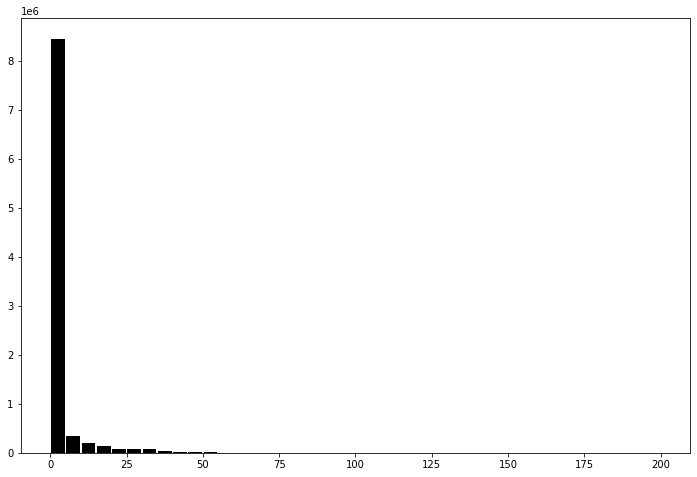

In [7]:
import geopy.distance
distances = []
Lat = gps['Lat'].values
Long = gps['Long'].values
for i in range(len(gps)-1):
    
    coords_1 = (Lat[i], Long[i])
    coords_2 = (Lat[i+1], Long[i+1])
    
    distances.append(geopy.distance.distance(coords_1, coords_2).m)
    
distances.append(0)

# Plotting
fig, ax = plt.subplots(figsize=(12,8))
ax.hist(distances,bins=np.arange(0,205,5),rwidth=0.9,color='black')

plt.show()
plt.close()

Doesn't seem to be any sort of cut-off value for the distances, we can check the minimum:

In [8]:
print(f'The minimum distance: {np.nanmin(distances)}')

The minimum distance: 0.0


So seems like there might be a combination of distance and timestamp. The next step would be to see what the timesteps between distances would be.

In [9]:
gps['Distance'] = distances
# looking at time between measurements
# short distances

gps_short_distance = gps[gps['Distance'] < 50]
dt = []
for i in range(len(gps_short_distance)-1):
    t = (gps_short_distance.index[i+1] - gps_short_distance.index[i]).total_seconds()
    dt.append(t)

# long distances
gps_long_distance = gps[gps['Distance'] > 50]
dt_long = []
for i in range(len(gps_long_distance)-1):
    t = (gps_long_distance.index[i+1] - gps_long_distance.index[i]).total_seconds()
    dt_long.append(t)
    

KeyboardInterrupt: 

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(12,8))
ax = axes[0]
ax.hist(dt,bins=np.arange(0,26,1),rwidth=0.9,color='black')

ax = axes[1]
ax.hist(dt_long,bins=np.arange(0,205,5),rwidth=0.9,color='black')

plt.show()
plt.close()

# Individual-Level Inspection
We want to look at a few individuals to get a sense of the data and what gaps are present. The entire study period is quite long so we can restrict the time frame if need be to get a better look.

In [ ]:
gps['Beiwe'].unique()

Choosing randomly from the list above (first, last, and somewhere in the middle), we can inspect the GPS data. We look at the Lat and Long values for each participant of interest to make sure they match up. 

In [ ]:
for pt in ['2xtqkfz1','xxvnhauv','itmylz3g']:
    fig, ax_lat = plt.subplots(figsize=(16,4))
    # gps data per individual
    gps_pt = gps[gps['Beiwe'] == pt]
    # restricting again for the date
    gps_pt = gps_pt[datetime(2020,6,7):datetime(2020,6,9)]
    # info per individual
    info_pt = info[info['Beiwe'] == pt]

    # Plotting Lat
    ax_lat.scatter(gps_pt.index,gps_pt['Lat'], color='cornflowerblue', s=5,label='Latitude')
    
    # Plotting Long on same axis
    ax_long = ax_lat.twinx()
    ax_long.scatter(gps_pt.index,gps_pt['Long'], color='firebrick', s=5, label='Longitude')
    
    plt.show()
    plt.close()

## Address Coordinate Overlap and Move-Out Dates

In [ ]:
for coord, color in zip(['Lat','Long'],['cornflowerblue','firebrick']):
    print(f'Looking at {coord}:')
    for pt in gps['Beiwe'].unique():
        if pt in info['Beiwe'].values:
            fig, ax = plt.subplots(figsize=(16,4))
            # gps data per individual
            gps_pt = gps[gps['Beiwe'] == pt]
            # info per individual
            info_pt = info[info['Beiwe'] == pt]

            ax.scatter(gps_pt.index,gps_pt[coord], color=color, s=5,alpha=0.5)
            ax.axhline(info_pt[coord].values[0],color='black',linestyle='dashed')
            ax.axvline(info_pt['move_date'].values[0],color='black',linestyle='dashed')
            ax.set_title(f'Beiwe: {pt}')

            plt.show()
            plt.close()
            
        else:
            print(f'Patient {pt} not given Beacon')

<div class="alert alert-block alert-danger">
Initial inspection shows that move-out dates do NOT correspond with the GPS data. 

## Beacon and GPS Overlap
Here we look to see if participants that logged Beacon data also logged GPS data.

In [15]:
beacon_df = pd.read_csv('../data/processed/bpeace2-beacon.csv',index_col=0)
# GPS
pt_list = []
bb_list = []
# info
info_pt_list = []
info_bb_list = []
for pt, bb in zip(beacon_df['Beiwe'].unique(),beacon_df['Beacon'].unique()):
    if pt in gps['Beiwe'].unique():
        pt_list.append(pt)
        bb_list.append(bb)
    if pt in info['Beiwe'].unique():
        info_pt_list.append(pt)
        info_bb_list.append(bb)

Comparing the beacons

In [16]:
print('Number of Beacon users with GPS logged:',len(bb_list))
print('\tGPS Beacons:', bb_list)
print('\tAll Beacons:', beacon_df['Beacon'].unique())
print('\tInfo Beacons:', info_bb_list)

Number of Beacon users with GPS logged: 24
	GPS Beacons: [1, 5, 6, 7, 10, 11, 15, 16, 17, 19, 21, 22, 24, 25, 26, 28, 29, 30, 32, 34, 36, 38, 40, 44]
	All Beacons: [ 1  5  6  7 10 11 15 16 17 19 21 22 24 25 26 28 29 30 32 34 36 38 40 44
 46]
	Info Beacons: [1, 5, 6, 7, 10, 11, 15, 16, 17, 19, 21, 22, 24, 25, 26, 28, 29, 30, 32, 34, 36, 38, 40, 44, 46]


<function print>